# Cluster Analysis Flow

## 1. Get the dataset and variables

In [1]:
import pandas as pd
import os
import csv

def read_data(dataset_name, x_col, y_col):
    if dataset_name.endswith('.csv'):
        data = pd.read_csv(dataset_name)
    X = data[x_col]
    Y = data[y_col]
    
    return data, X, Y

In [2]:
dataset_name = 'data/insurance.csv'
x_col, y_col = 'bmi', 'charges'
i_col = 'age'

In [3]:
data, X, Y = read_data(dataset_name, x_col, y_col)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## 1.1 Scale data

Scale the data to standardize `eps` distance for all datasets to be used in the DBSCAN model

In [4]:
from sklearn.preprocessing import StandardScaler

def scale_data(data):
    scaler = StandardScaler()
    data = data.to_numpy().reshape(-1,1)
    data = scaler.fit_transform(data)
    
    return data

In [5]:
X_scaled = scale_data(X)
Y_scaled = scale_data(Y)

#### Original dataset without scaling

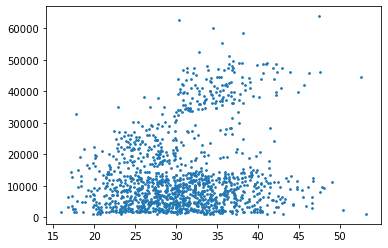

In [6]:
import matplotlib.pyplot as plt

plt.scatter(data[x_col], data[y_col], s=3)

#### Dataset with scaling

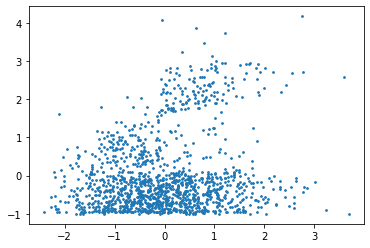

In [7]:
import matplotlib.pyplot as plt
plt.scatter(X_scaled, Y_scaled, s=3)

Note that the only the value ranges of the distribution changes.

## 2. Create DBSCAN model

In [8]:
from sklearn.cluster import DBSCAN
import numpy as np

# trying default values for eps, maybe I do need to scale so that it fits within the default range?
def create_dbscan_model(X, Y):
    dbscan = DBSCAN(eps=0.2)
    dbscan.fit(np.c_[X, Y])
    return dbscan

In [9]:
dbscan = create_dbscan_model(X_scaled, Y_scaled)

## 3. Identify Outliers

In [10]:
def get_outliers(dbscan, data):
    outlier_mask = dbscan.labels_ == -1
    return data.iloc[outlier_mask,:]

In [11]:
outliers = get_outliers(dbscan, data)
outliers

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
45,55,male,37.300,0,no,southwest,20630.28351
62,64,male,24.700,1,no,northwest,30166.61817
116,58,male,49.060,0,no,southeast,11381.32540
128,32,female,17.765,2,yes,northwest,32734.18630
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1303,43,male,27.800,0,yes,southwest,37829.72420
1317,18,male,53.130,0,no,southeast,1163.46270
1318,35,male,39.710,4,no,northeast,19496.71917


## 3. Get DBSCAN results

Includes:
    
- Number of clusters found
- Size of each cluster (rank in descending order)
- Number of outliers

In [12]:
def get_dbscan_results(dbscan):
    
    print('DBSCAN results')
    print('Number of outliers:', len(dbscan.labels_[dbscan.labels_==-1]))
    
    clusters = np.unique(dbscan.labels_)
    print('Number of Clusters:', len(clusters) - 1)
    
    print('Cluster size ranking:')
    sizes = {}
    for cluster in clusters[1:]:
        sizes[cluster] = len(dbscan.labels_[dbscan.labels_==cluster])
    # taken from stack overflow
    for size in sorted(sizes.items(), reverse=True, key=lambda item: item[1]):
        print(size)

In [13]:
get_dbscan_results(dbscan)

DBSCAN results
Number of outliers: 67
Number of Clusters: 7
Cluster size ranking:
(0, 1123)
(1, 106)
(2, 12)
(5, 9)
(6, 9)
(3, 6)
(4, 6)


## 4. Generate Visualization

Code to save the visualization as png

In [45]:
fig_ext = 'png'
dpi=300
def save_plot(name):
    # added bbox_inches, so legend doesn't get cutoff
    plt.savefig(os.path.join('images', name + '.png'), format=fig_ext, dpi=dpi, bbox_inches='tight')

def process_name(name):
    return ('_'.join(name.split())).lower()

This visualization code is used from the "Hands-On Machine Learning"book.

In [41]:
def plot_dbscan(dbscan, X, size):
    
    # make an array of zeroes, a zero for each instance
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    
    # Set all the instances marked as core instances as true
    core_mask[dbscan.core_sample_indices_] = True
    
    # Get all the anomalies instances
    anomalies_mask = dbscan.labels_ == -1
    
    # Get instances thatt are neither core or anomalies
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    # Plot all border of core instances, coloring them based on the core mask
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    # Plot the actual points (using smaller size)
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    
    # Plot the anomalies
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    
    # Plot the non core instances
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

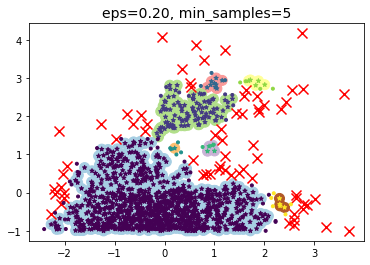

In [42]:
plot_dbscan(dbscan, np.c_[X_scaled, Y_scaled], size=100)

This visualization plots the points, coloring and labeling them by cluster.

In [43]:
from matplotlib.pyplot import cm

def plot_dbscan(dbscan, data, x_col, y_col):
    
    # Get all the anomalies instances
    outliers_mask = dbscan.labels_ == -1
    outliers = data[outliers_mask]
    
    # Get clusters
    clusters = np.unique(dbscan.labels_)[1:]
    
    # Plot each point, labeled and colored by its cluster
    color = cm.Set2(np.linspace(0,1,len(clusters)))
    for clust, c in zip(clusters, color):
        points = data[dbscan.labels_==clust]
        plt.scatter(points[:,0], points[:,1], color=c, s=20, label=clust)
    
    plt.scatter(outliers[:,0], outliers[:,1], c='r', s=30, marker='x')
    
    plt.tight_layout()
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(x_col + ' VS ' + y_col)
    
    # places legend to right of plot, taken from stackoverflow
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')
    
    save_plot(process_name(x_col) + '_vs_' + process_name(y_col))

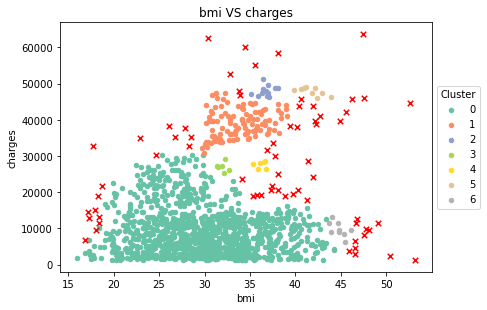

In [44]:
plot_dbscan(dbscan, np.c_[X,Y], x_col, y_col)